In [1]:
import sklearn.mixture
import numpy as np
import scipy as sp
from keras import Input
from keras.layers   import Dense, Lambda, Layer, Activation
from keras.models   import Model
from keras.layers.normalization import BatchNormalization
import keras.backend as K
import matplotlib.pyplot as plt
import autograd.numpy.random as npr
import pylab
from keras                   import backend
from sklearn.metrics         import adjusted_rand_score
%matplotlib inline
from sklearn.metrics import accuracy_score


/Users/tomohiromimura/.pyenv/versions/3.6.4/envs/normal/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def make_pinwheel_data(radial_std, tangential_std, num_classes, num_per_class, rate):
    rads = np.linspace(0, 2*np.pi, num_classes, endpoint=False)

    features = npr.randn(num_classes*num_per_class, 2) \
        * np.array([radial_std, tangential_std])
    features[:,0] += 1.
    labels    = np.repeat(np.arange(num_classes), num_per_class)

    angles    = rads[labels] + rate * np.exp(features[:,0])
    rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
    rotations = np.reshape(rotations.T, (-1, 2, 2))

    return 10*np.einsum('ti,tij->tj', features, rotations),labels

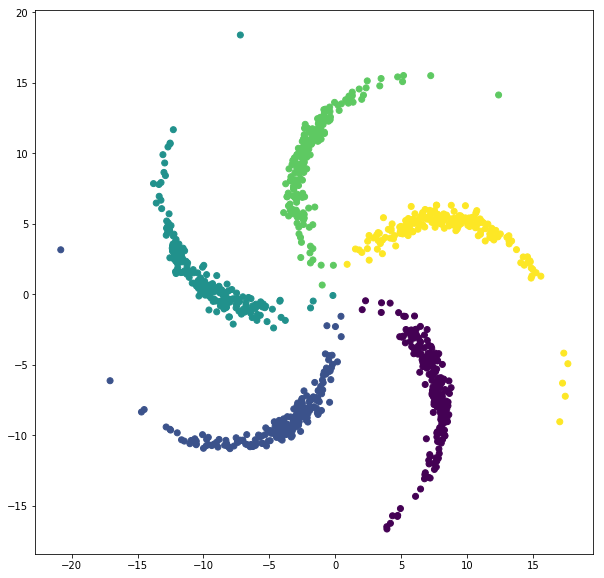

In [3]:
num_clusters        = 5      # number of clusters in pinwheel data
samples_per_cluster = 200    # number of samples per cluster in pinwheel
K = 15                       # number of components in mixture model
N = 2                        # number of latent dimensions
P = 2                        # number of observation dimensions
batch_size          = num_clusters * samples_per_cluster
data, label = make_pinwheel_data(0.3, 0.05, num_clusters, samples_per_cluster, 0.25)

plt.figure(figsize=(10,10))
pylab.scatter(data[:,0],data[:,1],c=label)

In [4]:
def vae_loss(y_true, y_pred):
    # 入力と出力の交差エントロピー
    xent_loss =   backend.sum((backend.square(y_true - y_mean))/(backend.exp(y_log_var)) + backend.log(np.pi * 2) + y_log_var, axis=-1) * 0.5
    # 事前分布と事後分布のKL情報量
    kl_loss   =   backend.sum((backend.square(z - z_mean))/(backend.exp(z_log_var)) + backend.log(np.pi * 2) + z_log_var, axis=-1) * 0.5
    return backend.mean(xent_loss  - kl_loss - gmm_loss)


def sampling(args):
    mean, log_var = args
    epsilon = backend.random_normal(shape=backend.shape(mean), mean=0.,stddev=1.)
    return mean + backend.exp(log_var / 2) * epsilon

In [5]:
original_dim      = data.shape[1]
intermediate_dim  = 100
latent_dim        = 2

x                 = Input(shape=(original_dim,))
gmm_loss          = Input(shape=(1,))

decoder           = Dense(intermediate_dim)(x)
decoder           = BatchNormalization()(decoder)
decoder           = Activation('tanh')(decoder)



z_mean            = Dense(latent_dim,activation='linear')(decoder)
z_log_var         = Dense(latent_dim,activation='linear')(decoder)

z                 = Lambda(sampling,   output_shape=(latent_dim,))([z_mean, z_log_var])

decoder           = Dense(intermediate_dim)(z)
decoder           = BatchNormalization()(decoder)
decoder           = Activation('tanh')(decoder)


y_mean            = Dense(original_dim,activation='linear')(decoder)
y_log_var         = Dense(original_dim,activation='linear')(decoder)

y                 = Lambda(sampling, output_shape=(original_dim,))([y_mean, y_log_var])

VAE               = Model(input=[x,gmm_loss], output=y)
VAE_latent        = Model(input=x, output=z)

VAE_latent_mean   = Model(input=x, output=z_mean)
VAE_latent_var    = Model(input=x, output=z_log_var)
VAE_predict_mean  = Model(input=x, output=y_mean)
VAE_predict_var   = Model(input=x, output=y_log_var)

VAE.compile(optimizer='adam', loss=vae_loss)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          300         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 100)          400         dense_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 100)          0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dense_2 (D

/Users/tomohiromimura/.pyenv/versions/3.6.4/envs/normal/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`
/Users/tomohiromimura/.pyenv/versions/3.6.4/envs/normal/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`
/Users/tomohiromimura/.pyenv/versions/3.6.4/envs/normal/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/Users/tomohiromimura/.pyenv/versions/3.6.4/envs/normal/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/Users/tomohiromimura/.pyenv/versions/3.6.4/envs/normal/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWa

In [10]:
from scipy.stats import multivariate_normal
epoch  = 500
latent = VAE_latent.predict(data)
gmm    = sklearn.mixture.GaussianMixture(n_components=num_clusters, covariance_type='full', max_iter=1)
for i in range(1):
    gmm.fit(latent)
    
pi_i   = gmm.predict_proba(latent)
mu_    = gmm.means_
sigma_ = gmm.covariances_

liklyhood = np.zeros(data.shape[0])

for m,s,pi in zip(mu_,sigma_,pi_i.T):
    liklyhood += pi*multivariate_normal.logpdf(latent,m,s)
    
for i in range(epoch):
    loss   = VAE.train_on_batch([data,liklyhood],data)
    latent = VAE_latent.predict(data)
    gmm.fit(latent)
    liklyhood = np.zeros(data.shape[0])
    for m,s,pi in zip(mu_,sigma_,pi_i.T):
        liklyhood += pi*multivariate_normal.logpdf(latent,m,s)
        
    print(i,loss,adjusted_rand_score(gmm.predict(latent),label),liklyhood.mean())

    

/Users/tomohiromimura/.pyenv/versions/3.6.4/envs/normal/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


0 103.41993 0.14651976688765464 -4.642745632400823
1 95.59113 0.12824113232861528 -4.768401059745967
2 87.78585 0.1427903809605796 -5.087102852087367
3 79.762024 0.12900684280492689 -5.095885069702208
4 73.61033 0.14716991183681807 -5.224178837160909
5 69.6406 0.1516915803066779 -5.321435847776818
6 63.365334 0.17547067308204586 -5.448860569112303
7 61.06198 0.15748745211492618 -5.547109175062757
8 57.81444 0.16493515084376786 -5.875019881697466
9 55.200344 0.17322788825720362 -5.922366681168228
10 53.785786 0.1994689807213474 -6.31613884267172
11 52.853863 0.20554879153442485 -6.427000457735698
12 50.0747 0.19929126174245684 -6.586035789843281
13 49.4235 0.2444029770832334 -7.113938276925496
14 48.939808 0.20281728465848078 -7.0752181247013874
15 48.175327 0.2479702379579886 -7.197497229914569
16 47.22448 0.24044023733156006 -7.74776051846974
17 47.204098 0.23132759000805986 -7.727132936996007
18 46.164593 0.25417393033220814 -8.361216120912708
19 46.21272 0.2623205017144226 -8.257024

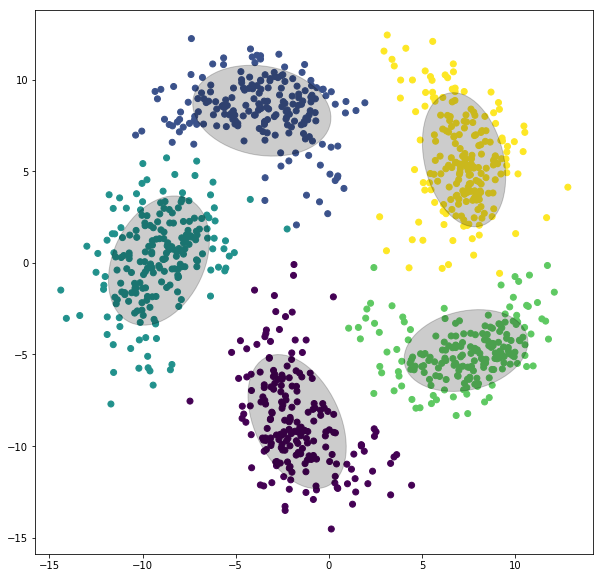

In [11]:
import matplotlib as mpl

plt.figure(figsize=(10,10))
ax = plt.axes()
for n in set(gmm.predict(latent)):
    covariances = gmm.covariances_[n][:2, :2]
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                              180 + angle, color='k')
    ell.set_alpha(0.2)
    ax.add_patch(ell)
    
pylab.scatter(latent[:,0],latent[:,1],c=gmm.predict(latent))




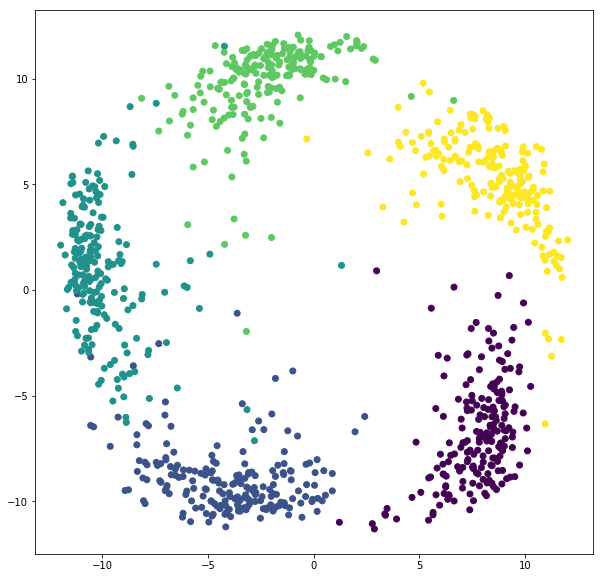

In [12]:
plt.figure(figsize=(10,10))
pylab.scatter(VAE_predict_mean.predict(data)[:,0],VAE_predict_mean.predict(data)[:,1],c=label)


In [13]:
gmm.predict(latent)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,

In [14]:
import pandas as pd
result  = gmm.predict(latent)
df      = pd.DataFrame({ 'result' : gmm.predict(latent),'label' : label})
iremono = np.zeros((5,5))
for i in range(5):
    acc = df[df['label']==i]
    for j in range(5):
        iremono[i,j] = len(acc[acc['result']==j])
acc = iremono.max(1).sum()/len(label)
print(acc)   

0.982
